# 1. Install Dependencies and Setup

In [1]:
import tensorflow as tf
import os

2024-06-17 23:18:23.058156: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [4]:
import cv2
import imghdr

/var/folders/82/qn51253x3v9b1jx2qm_rhv700000gn/T/ipykernel_11338/4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [5]:
data_dir = 'data' 

In [6]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [7]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [8]:
import numpy as np
from matplotlib import pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [9]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [10]:
data_iterator = data.as_numpy_iterator()

In [11]:
batch = data_iterator.next()

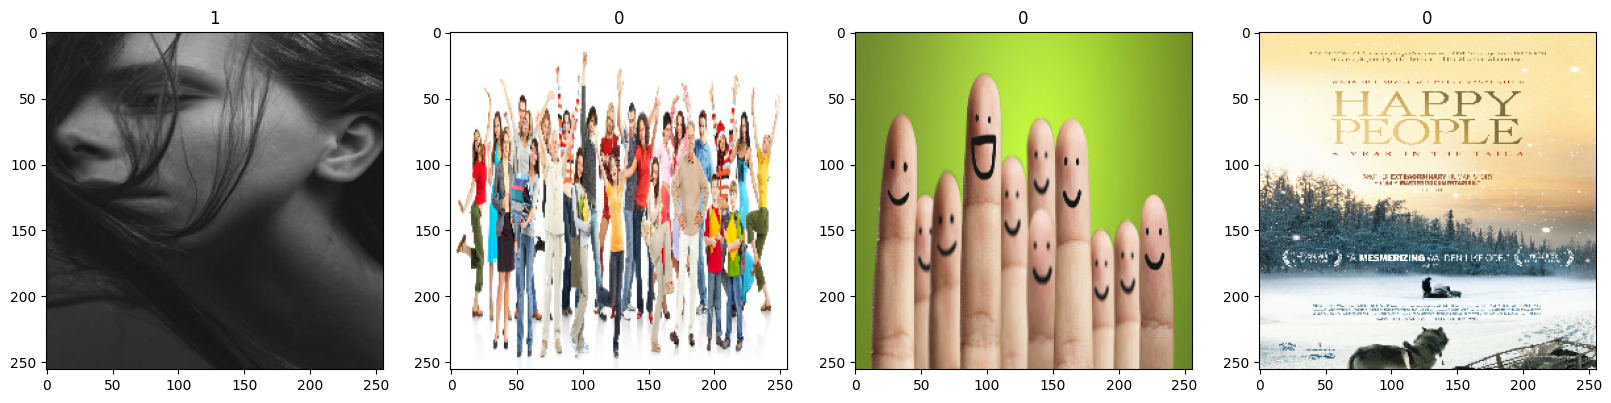

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [13]:
data = data.map(lambda x,y: (x/255, y))

In [14]:
data.as_numpy_iterator().next()

(array([[[[0.99725556, 0.7375577 , 0.78270227],
          [0.9885786 , 0.6611808 , 0.6953666 ],
          [0.9859375 , 0.5843507 , 0.55476147],
          ...,
          [0.9020995 , 0.6478742 , 0.38825408],
          [0.8772347 , 0.6146482 , 0.37928563],
          [0.8845294 , 0.6389565 , 0.39019248]],
 
         [[0.99043304, 0.7578935 , 0.8037215 ],
          [0.98664755, 0.68013173, 0.71388775],
          [0.9720087 , 0.5791165 , 0.6084887 ],
          ...,
          [0.954893  , 0.7050324 , 0.47559744],
          [0.90777564, 0.65329266, 0.43952745],
          [0.86856246, 0.6489574 , 0.41157347]],
 
         [[0.9974814 , 0.7340922 , 0.8060438 ],
          [0.99774814, 0.69494593, 0.7313456 ],
          [0.98193645, 0.54278564, 0.6181992 ],
          ...,
          [0.9107149 , 0.6602105 , 0.41071346],
          [0.8956326 , 0.64673555, 0.4004099 ],
          [0.852825  , 0.64388186, 0.3972254 ]],
 
         ...,
 
         [[0.64954007, 0.70489335, 0.84931487],
          [0.74529

# 5. Split Data

In [15]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [16]:
train_size

7

In [17]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [18]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [20]:
model = Sequential()

In [21]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [24]:
logdir='logs'

In [25]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [26]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 842ms/step - accuracy: 0.4799 - loss: 0.8707 - val_accuracy: 0.5312 - val_loss: 0.5985
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 832ms/step - accuracy: 0.5732 - loss: 0.5869 - val_accuracy: 0.8125 - val_loss: 0.4994
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 865ms/step - accuracy: 0.7956 - loss: 0.5490 - val_accuracy: 0.7969 - val_loss: 0.4331
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 871ms/step - accuracy: 0.8773 - loss: 0.4212 - val_accuracy: 0.7969 - val_loss: 0.4359
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 910ms/step - accuracy: 0.7757 - loss: 0.4894 - val_accuracy: 0.7969 - val_loss: 0.4087
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 826ms/step - accuracy: 0.8802 - loss: 0.3214 - val_accuracy: 0.9062 - val_loss: 0.2571
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 849ms/step - accuracy: 0.9324 - loss: 0.2212 - val_accuracy: 0.7344 - val_loss: 0.4203
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 844ms/step - accuracy: 0.8794 - loss: 0.3204 - val_accuracy: 0.9688 - val_loss:

# 8. Plot Performance

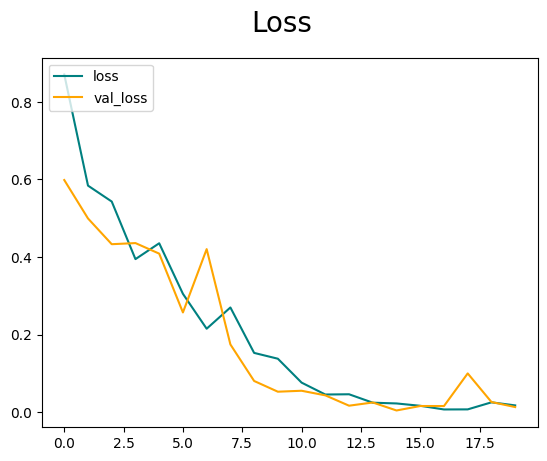

In [27]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

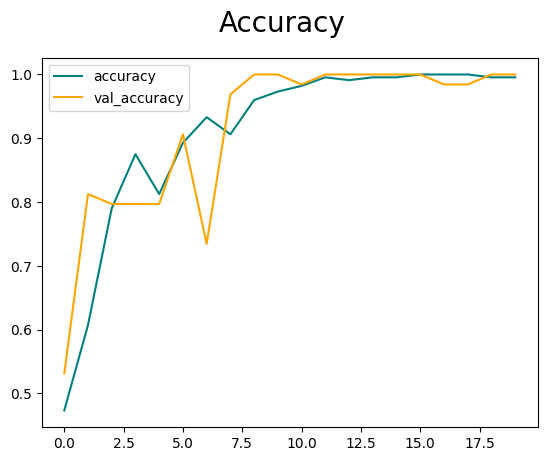

In [28]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [29]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [30]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [31]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


2024-06-17 23:27:48.882673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [32]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [33]:
import cv2

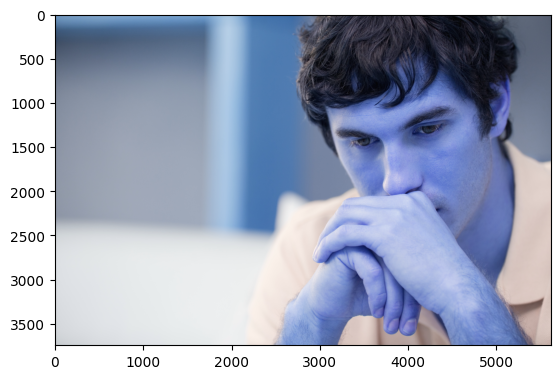

In [54]:
img = cv2.imread('8iAb9k4aT.jpg')
plt.imshow(img)
plt.show()

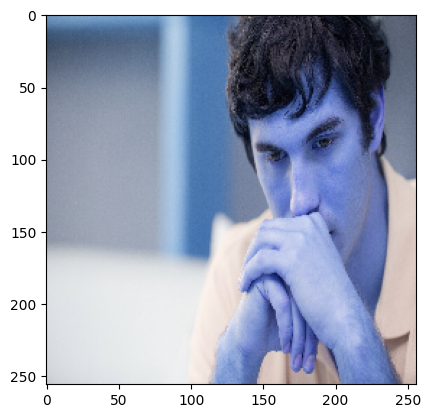

In [55]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [56]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [57]:
yhat

array([[0.99943155]], dtype=float32)

In [58]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


# 11. Save the Model

In [39]:
from tensorflow.keras.models import load_model

In [40]:
model.save(os.path.join('models','imageclassifier.h5'))

In [43]:
new_model = load_model('models/imageclassifier.h5')

In [44]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


array([[0.91113544]], dtype=float32)